In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['10k_actual_train.csv', '10kactual_test.csv']


In [2]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [38]:
from sklearn.metrics import accuracy_score

In [3]:
from hyperopt import hp, tpe
from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [41]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Automatically created module for IPython interactive environment


In [4]:
train = pd.read_csv('../input/10k_actual_train.csv')
test = pd.read_csv('../input/10kactual_test.csv')

In [5]:
train.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,city,bd,gender,...,trans_month,trans_year,expire_month,expire_year,registration_month,registration_year,membership_duration,autorenew_._not_cancel,registration_duration,reg_mem_duration
0,280470,not_churn,41,30,149,149,1,5,21,0,...,12,2016,1,2017,3,2015,31,1,672,641
1,346351,not_churn,40,31,149,149,1,5,45,0,...,3,2015,4,2015,1,2012,32,1,1159,1127
2,117510,not_churn,34,0,0,149,1,5,30,1,...,6,2015,7,2015,7,2006,31,1,3316,3285
3,183044,not_churn,40,30,149,149,1,13,42,0,...,10,2015,11,2015,5,2007,30,1,3098,3068
4,109458,not_churn,40,30,149,149,1,15,24,1,...,9,2016,10,2016,1,2009,29,1,2821,2792


In [6]:
test.head()

,msno,is_churn,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,city,bd,gender,...,trans_month,trans_year,expire_month,expire_year,registration_month,registration_year,membership_duration,autorenew_._not_cancel,registration_duration,reg_mem_duration
0,245780,not_churn,38,30,149,149,0,13,21,1,...,3,2015,4,2015,1,2014,30,0,462,432
1,69532,not_churn,38,30,149,149,0,13,18,0,...,10,2015,11,2015,10,2015,30,0,36,6
2,59826,not_churn,39,30,149,149,1,6,41,1,...,1,2017,3,2017,6,2012,40,1,1738,1698
3,46736,not_churn,40,30,149,149,1,4,31,0,...,5,2016,6,2016,9,2013,34,1,1010,976
4,306040,not_churn,36,30,150,150,0,1,0,0,...,9,2015,10,2015,8,2014,33,0,413,380


In [7]:
train.loc[ train.is_churn == 'not_churn', 'is_churn'] = 0
train.loc[ train.is_churn == 'churn', 'is_churn'] = 1

In [8]:
train['is_churn'] = train['is_churn'].astype(int)

In [9]:
test.loc[ test.is_churn == 'not_churn', 'is_churn'] = 0
test.loc[ test.is_churn == 'churn', 'is_churn'] = 1

In [10]:
test['is_churn'] = test['is_churn'].astype(int)

In [11]:
# Some useful parameters which will come in handy later on
ntrain = train.shape[0]
ntest = test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
        
    def predict_proba(self, x_test):
        return self.clf.predict_proba(x_test)[:,1]
    
# Class to extend XGboost classifer

In [12]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [13]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 2,
    'min_samples_leaf': 6,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [14]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [15]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['is_churn'].ravel()
x_train = train.drop('is_churn', axis=1)
x_train = x_train.values # Creates an array of the train data
x_test = test.drop('is_churn', axis=1)
x_test = x_test.values # Creats an array of the te

In [18]:
y_test = test['is_churn'].values

In [16]:
rf.fit(x_train, y_train)
pred_rf = rf.predict(x_test)

In [ ]:
pred_rf

In [19]:
from sklearn.metrics import roc_auc_score
rf_roc = roc_auc_score(y_test,pred_rf )

In [20]:
from sklearn.metrics import roc_curve
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, rf.predict_proba(x_test))

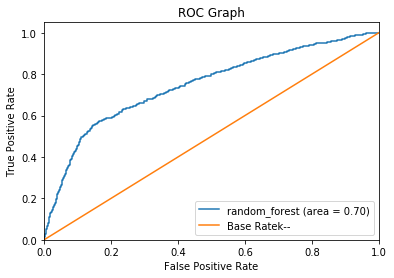

In [21]:
plt.figure()
plt.plot(rf_fpr, rf_tpr, label='random_forest (area = %0.2f)' % rf_roc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [22]:
et.fit(x_train, y_train)
pred_et = et.predict(x_test)

In [23]:
et_roc = roc_auc_score(y_test,pred_et)

In [24]:
et_fpr, et_tpr, thresholds = roc_curve(y_test, et.predict_proba(x_test))

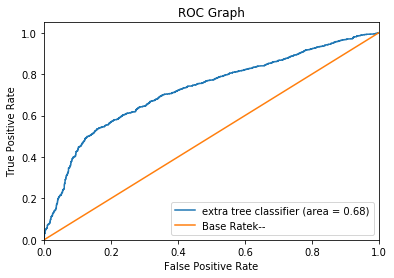

In [25]:
plt.figure()
plt.plot(et_fpr, et_tpr, label='extra tree classifier (area = %0.2f)' % et_roc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [26]:
ada.fit(x_train, y_train)
pred_ada = ada.predict(x_test)

In [27]:
ada_roc = roc_auc_score(y_test,pred_ada)

In [28]:
ada_fpr, ada_tpr, thresholds = roc_curve(y_test, ada.predict_proba(x_test))

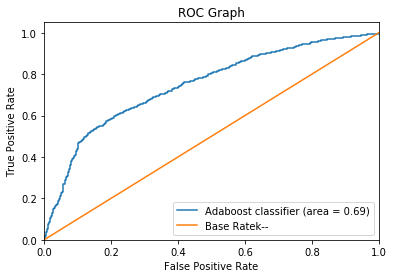

In [29]:
plt.figure()
plt.plot(ada_fpr, ada_tpr, label='Adaboost classifier (area = %0.2f)' % ada_roc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [30]:
gb.fit(x_train, y_train)
pred_gb = gb.predict(x_test)

In [31]:
gb_roc = roc_auc_score(y_test,pred_gb)

In [32]:
gb_fpr, gb_tpr, thresholds = roc_curve(y_test, gb.predict_proba(x_test))

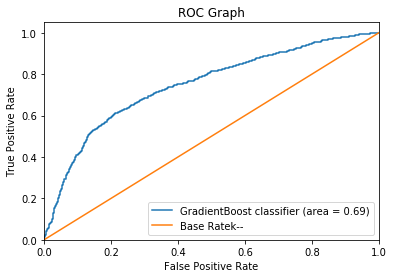

In [33]:
plt.figure()
plt.plot(gb_fpr, gb_tpr, label='GradientBoost classifier (area = %0.2f)' % gb_roc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

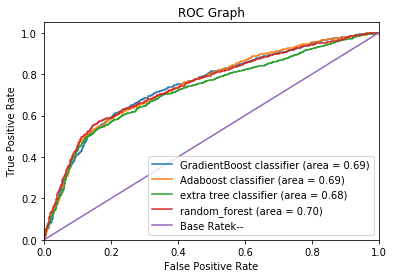

In [34]:
plt.figure()
plt.plot(gb_fpr, gb_tpr, label='GradientBoost classifier (area = %0.2f)' % gb_roc)
plt.plot(ada_fpr, ada_tpr, label='Adaboost classifier (area = %0.2f)' % ada_roc)
plt.plot(et_fpr, et_tpr, label='extra tree classifier (area = %0.2f)' % et_roc)
plt.plot(rf_fpr, rf_tpr, label='random_forest (area = %0.2f)' % rf_roc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
y_train = train['is_churn'].ravel()
x_train = train.drop('is_churn', axis=1)
x_train = x_train.values # Creates an array of the train data
x_test = test.drop('is_churn', axis=1)
x_test = x_test.values # Creats an array of the te

In [ ]:
y_test = test['is_churn'].values

In [35]:
ex = ExtraTreesClassifier(
    #learning_rate = 0.02,
     n_jobs = -1,
     n_estimators = 500,
    #'max_features': 0.5,
     max_depth = 8,
     min_samples_leaf = 2,
     verbose = 0).fit(x_train, y_train)
predictions = ex.predict(x_test)

In [36]:
predictions

array([1, 1, 0, ..., 1, 1, 1])

In [39]:
accuracy_score(y_test, predictions)

0.6946778711484594

In [43]:
clas = np.array(['churn','not_churn'])
clas

array(['churn', 'not_churn'], dtype='<U9')

extra tree Confusion matrix, without normalization
[[1095  166]
 [ 597  641]]
extra tree Normalized confusion matrix
[[0.87 0.13]
 [0.48 0.52]]


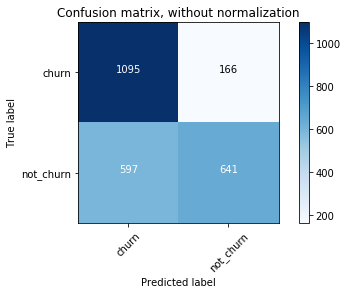

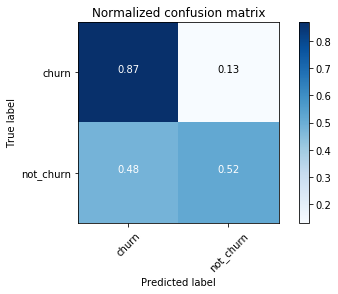

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("extra tree Normalized confusion matrix")
    else:
        print('extra tree Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [45]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
print("extra")
print("Training is complete")

extra
Training is complete


In [46]:
et_oof_test.shape

(2499, 1)

In [53]:
et_oof_test[87]

array([0.4])

In [54]:
et_oof_train.shape

(7501, 1)

In [55]:
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
print("forest")


forest


In [56]:
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
print("ada")


ada


In [57]:
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
print("grad")

grad


In [58]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.02 0.06 0.01 0.02 0.02 0.23 0.01 0.03 0.   0.01 0.01 0.01 0.01 0.01
 0.01 0.02 0.1  0.33 0.03 0.04]
[2.29e-04 1.81e-02 3.61e-02 3.24e-02 2.82e-02 2.82e-01 4.18e-04 1.15e-02
 3.61e-04 3.78e-02 1.07e-03 1.11e-03 2.82e-03 5.23e-03 3.76e-04 7.18e-02
 2.19e-02 3.35e-01 5.43e-02 5.93e-02]
[0.24 0.12 0.   0.02 0.02 0.   0.01 0.09 0.   0.   0.01 0.   0.04 0.
 0.   0.02 0.12 0.   0.16 0.14]
[0.24 0.04 0.01 0.01 0.01 0.01 0.06 0.1  0.02 0.01 0.04 0.01 0.04 0.01
 0.05 0.02 0.06 0.03 0.12 0.11]


In [59]:
rf_features = [0.01756911, 0.0627274,  0.00888048, 0.02459727, 0.02426118, 0.2297879,
 0.0078791,  0.03310744, 0.00191328, 0.01108822, 0.01011235, 0.0073031,
 0.0129614,  0.00644591, 0.00918351, 0.02271843, 0.10061091, 0.33043497,
 0.03434471, 0.04407334]
et_features = [2.28510724e-04, 1.80830719e-02, 3.61323817e-02, 3.23926971e-02,
 2.81802352e-02, 2.81807550e-01, 4.17996750e-04, 1.14585376e-02,
 3.61159932e-04, 3.77749497e-02, 1.07368313e-03, 1.11176474e-03,
 2.82294873e-03, 5.22520761e-03, 3.76234810e-04, 7.17671446e-02,
 2.18515219e-02, 3.35278641e-01, 5.43186072e-02, 5.93371550e-02]
ada_features = [0.236, 0.122, 0.002, 0.016, 0.024, 0.002, 0.008, 0.086, 0.002, 0.002, 0.01, 0.002,
 0.042, 0.002, 0.004, 0.022, 0.116, 0.002, 0.162, 0.138]
gb_features = [0.24221627, 0.04276541, 0.00560166, 0.0119653, 0.01299966, 0.00703854,
 0.05643939, 0.10266292, 0.01659545, 0.01485705, 0.03719272, 0.01029425,
 0.04231092, 0.01177388, 0.04818219, 0.02169362, 0.05691861, 0.02881548,
 0.11817149, 0.11150517]

In [60]:
cols = np.array(['msno', 'payment_method_id', 'payment_plan_days',
       'plan_list_price', 'actual_amount_paid', 'is_auto_renew', 'city',
       'bd', 'gender', 'registered_via', 'trans_month', 'trans_year',
       'expire_month', 'expire_year', 'registration_month',
       'registration_year', 'membership_duration',
       'autorenew_._not_cancel', 'registration_duration',
       'reg_mem_duration'])

In [61]:
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [62]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [63]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.236,0.000229,0.242216,0.017569,msno,0.124003
1,0.122,0.018083,0.042765,0.062727,payment_method_id,0.061394
2,0.002,0.036132,0.005602,0.008880,payment_plan_days,0.013154


In [64]:
feature_dataframe.shape

(20, 6)

In [65]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [66]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0


In [67]:
base_predictions_train.shape

(7501, 4)

In [ ]:
base_predictions_train.shape

In [68]:
train.shape

(7501, 21)

In [69]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [70]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

In [71]:
x_train.shape, x_test.shape

((7501, 4), (2499, 4))

In [72]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 eta = 0.1,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [ ]:
test.head()

In [ ]:
predictions

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
y_test = test['is_churn']
y_test = y_test.values

In [73]:
accuracy_score(y_test, predictions)

0.4965986394557823

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[  58 1203]
 [  55 1183]]
Normalized confusion matrix
[[0.05 0.95]
 [0.04 0.96]]


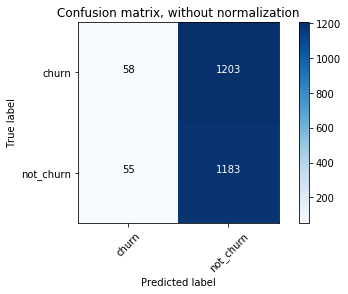

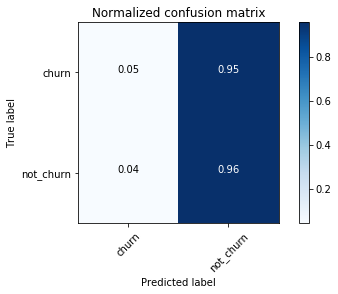

In [74]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
y

In [ ]:
clas = np.array(['churn','not_churn'])
clas

In [80]:
X = train.drop('is_churn', axis = 1)
Y = train['is_churn']

In [84]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'eta': '{:.3f}'.format(params['eta'])
       # 'n_estimators': '{:.3f}'.format(params['n_estimators']),
    }
    
    clf = xgb.XGBClassifier(
        n_estimators=250,
        learning_rate=0.05,
        n_jobs=4,
        **params
    )
    
    score = cross_val_score(clf, X, Y, cv=StratifiedKFold()).mean()
    print("score {:.3f} params {}".format(score, params))
    return score

In [76]:
print("Hyperopt estimated optimum {}".format(best))

NameError: name 'best' is not defined

In [85]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.2),
    'eta': hp.uniform('eta', 0.01, 0.3)
    #'n_estimators': hp.uniform('n_estimators', 500, 2000)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

score 0.706 params {'max_depth': 2, 'gamma': '0.087', 'colsample_bytree': '0.905', 'eta': '0.011'}
score 0.705 params {'max_depth': 5, 'gamma': '0.136', 'colsample_bytree': '0.667', 'eta': '0.179'}
score 0.698 params {'max_depth': 8, 'gamma': '0.026', 'colsample_bytree': '0.902', 'eta': '0.066'}
score 0.699 params {'max_depth': 7, 'gamma': '0.037', 'colsample_bytree': '0.909', 'eta': '0.062'}
score 0.696 params {'max_depth': 7, 'gamma': '0.072', 'colsample_bytree': '0.875', 'eta': '0.042'}
score 0.696 params {'max_depth': 8, 'gamma': '0.111', 'colsample_bytree': '0.673', 'eta': '0.075'}
score 0.706 params {'max_depth': 6, 'gamma': '0.071', 'colsample_bytree': '0.593', 'eta': '0.205'}
score 0.696 params {'max_depth': 8, 'gamma': '0.158', 'colsample_bytree': '0.480', 'eta': '0.128'}
score 0.698 params {'max_depth': 6, 'gamma': '0.023', 'colsample_bytree': '0.835', 'eta': '0.239'}
score 0.707 params {'max_depth': 4, 'gamma': '0.035', 'colsample_bytree': '0.750', 'eta': '0.134'}


In [86]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'colsample_bytree': 0.8753686771550262, 'eta': 0.0421341221237833, 'gamma': 0.07162877280714029, 'max_depth': 7.0}


In [81]:
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }
    
    clf = ExtraTreesClassifier(
        n_estimators=500,
        n_jobs = -1,
        verbose = 0,
        **params
    )
    
    score = cross_val_score(clf, X, Y, cv=StratifiedKFold()).mean()
    print("score {:.3f} params {}".format(score, params))
    return score

In [82]:
space = {
    'max_depth': hp.quniform('max_depth', 2, 10, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 10, 1)
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=10)

score 0.702 params {'max_depth': 5, 'min_samples_leaf': 4}
score 0.703 params {'max_depth': 5, 'min_samples_leaf': 9}
score 0.706 params {'max_depth': 8, 'min_samples_leaf': 9}
score 0.701 params {'max_depth': 5, 'min_samples_leaf': 10}
score 0.707 params {'max_depth': 8, 'min_samples_leaf': 7}
score 0.707 params {'max_depth': 8, 'min_samples_leaf': 2}
score 0.707 params {'max_depth': 8, 'min_samples_leaf': 3}
score 0.699 params {'max_depth': 4, 'min_samples_leaf': 2}
score 0.699 params {'max_depth': 4, 'min_samples_leaf': 2}
score 0.706 params {'max_depth': 10, 'min_samples_leaf': 9}


In [83]:
print("Hyperopt estimated optimum {}".format(best))

Hyperopt estimated optimum {'max_depth': 4.0, 'min_samples_leaf': 2.0}
